# **Landing a spacecraft using PINNs**

---
---

This code will contain an attempt to simulate the landing of a spacecraft as controlled by a Physics Informed neural network as described in the following [paper](https://www.nature.com/articles/s41598-023-49977-3.pdf). 

#### Physical description

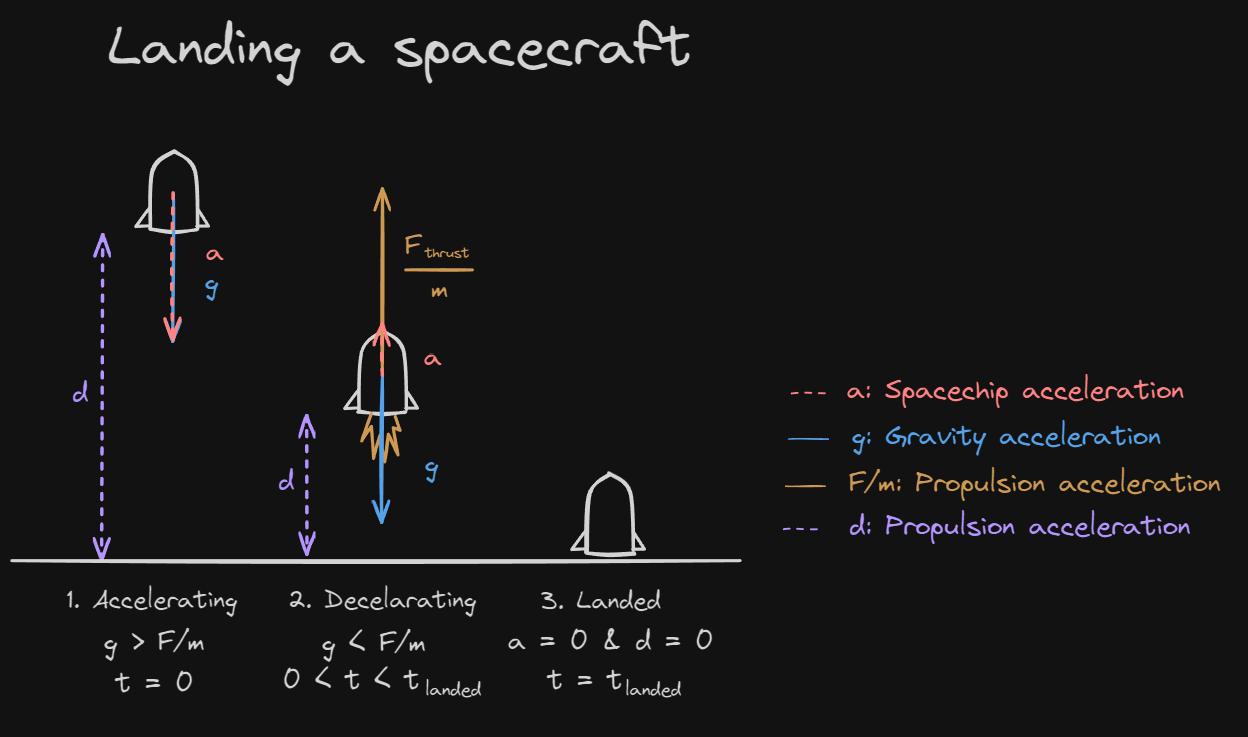

The equation governing the acceleration of the spacecraft can be written down as:
$$\frac{F_{thrust}}{m} − g - a = 0$$

#### Goal

From an initial state with height $d$, veloxity $v$, and acceleration $a$ we would like to end up at ground level ($d = 0$) with no velocity ($v = 0$). This will be concidered a succesful landing.

The initial conditions are given by:

$$\{ d,v,a \} = \{ 0,0,g \} \; \textup{at} \; t = 0 \; \textup{s}$$

#### Boundary conditions / constraints

1. The maximum thrust is limited and cannot be negative: $0 \leq  F_{thrust} \leq F_{max}$ (limited via tanh)
2. At no point can $d < 0$

#### Loss


**Physics:**

$$L_{phys}(d)=\frac1{N_{\Omega}}\sum_{j=1}^{N_{\Omega}}\|\mathcal{F}(t_j;d)\|_2^2\mathrm{~for~}t_j\in\Omega.$$

* $L_{phys}(d)$: This is the physics loss, which quantifies the deviation of the neural network predictions from the governing physics equations.
* $\frac1{N_{\Omega}}\sum_{j=1}^{N_{\Omega}}$: This part calculates the average over a set of samples within the domain $\Omega$. $N_{\Omega}$ represents the number of samples taken within the domain.
* $\| \mathcal{F}(t_j; d) \|_2^2$: This term measures the squared Euclidean norm of the residual function $\mathcal{F}(t_j; d) $ at each sample point $t_j$ within the domain. Here, $\mathcal{F}(t_j; d)$ represents the residual of the governing physics equation at time $t_j$ given by the distance $d$.

The residual of the governing physics equation is given by:
$$\mathcal{F}= \frac{F_{thrust}}{m} − g - \ddot{d}$$

**Constraints:**

The constraints are given by the following formuls:
$$L_{con}(d)=\frac1{N_{\partial\Omega}}\sum_{j=1}^{N_{\partial\Omega}}\|\hat{u}(t_j;d)-BC(t_j, d)\|_2^2$$

Where the boandary condition is:

$$BC(t_j, d) = \left\{\begin{matrix}
\hat{u}(t_j;d) \: \textup{for} \:  d \: \geq 0
\\ 
0 \: \textup{for} \: d < 0
\end{matrix}\right.$$

**Goal:**
The goal loss can be simply stated as:
$$L_{goal}(d) = d^2 \; \textup{at} \; t = t_{max}$$

**Weights:**
$$\{ w_{phys},w_{con},w_{goal} \} = \{ 1,1,1 \}$$

For optimisation:

$$d\to d^*=\operatorname*{argmin}_{d}\{w_{\mathrm{phys}}L_{\mathrm{phys}}(d)+w_{\mathrm{con}}L_{\mathrm{con}}(d)+w_{\mathrm{goal}}L_{\mathrm{goal}}(d)\}$$





Training..
Adam 0:	Physics:	520.5217	Constraint:	10.2659	Goal:	503236.9062	Total:	50324212.0000
Adam 100:	Physics:	21.7280	Constraint:	2058.9507	Goal:	116.1903	Total:	11642.8184
Adam 200:	Physics:	15.1735	Constraint:	1987.9425	Goal:	0.0047	Total:	17.6265
Adam 300:	Physics:	12.3081	Constraint:	1435.1792	Goal:	0.0003	Total:	13.7753
Adam 400:	Physics:	11.0659	Constraint:	1026.8900	Goal:	0.0000	Total:	12.0963
Adam 500:	Physics:	10.1562	Constraint:	814.9424	Goal:	0.0001	Total:	10.9854
Adam 600:	Physics:	9.2442	Constraint:	704.3434	Goal:	0.0000	Total:	9.9486
Adam 700:	Physics:	8.3190	Constraint:	634.4783	Goal:	0.0043	Total:	9.3833
Adam 800:	Physics:	7.4223	Constraint:	577.6714	Goal:	0.0000	Total:	8.0036
Adam 900:	Physics:	6.5669	Constraint:	523.7015	Goal:	0.0017	Total:	7.2648
Adam 1000:	Physics:	5.7767	Constraint:	470.7986	Goal:	0.0001	Total:	6.2617
Adam 1100:	Physics:	5.0532	Constraint:	418.9703	Goal:	0.0000	Total:	5.4722
Adam 1200:	Physics:	4.4032	Constraint:	369.9695	Goal:	0.0001	Total:	4

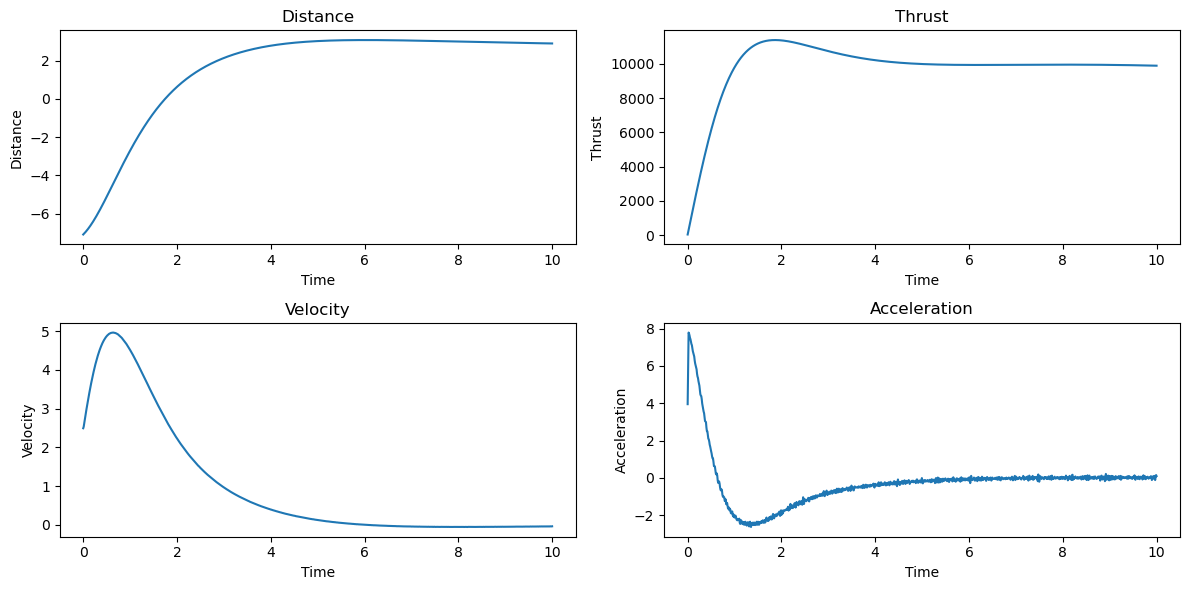

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
import torch
import matplotlib.pyplot as plt
from torch.autograd import grad

class FNN(nn.Module):
    def __init__(self, layers):
        super().__init__()

        self.linears = nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)
        ])
        self.activation = F.tanh

        # initialize (Glorot normal)
        for layer in self.linears:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
            #nn.init.xavier_normal_(layer.bias)

    def forward(self, x):
        for layer in self.linears[:-2]:
            x = self.activation(layer(x))
            
        return self.linears[-1](x)
    

# hyperparameters

n_output = 2 # distance, thruster_force

max_thrust = 10000 # Newton
max_distance = 200 # Newton
tmin, tmax = 0.0, 10.0
m = 1000 # kg
g = -10 # m/s^2 

# distance, distance_d, distance_dd, thrust
initial_conditions = [100, 0, g, 0]
initial_condition_weights = [1, 1, 1, 1]

goal_conditions = [0, 0] # distance, distance_d
goal_condition_weights = [1, 1]

loss_weights = [1, 1, 100] # physics, constraints, goal

n_adam = 5000
n_bfgs = 5000
n_domain = 1000
device = "cpu"

distance = None
distance_d = None
distance_dd = None
thrust = None

net = FNN([1] + [64] * 3 + [n_output])

time_domain = torch.linspace(tmin, tmax, n_domain)
time_domain = time_domain.reshape((n_domain, 1))
step = tmax / 1000


def physics_loss(distance, distance_d, distance_dd, thrust):
    
    thruster_acceleration = thrust / m
    acceleration_sums = thruster_acceleration + g + distance_dd
    acceleration_losses = acceleration_sums**2

    loss = torch.mean(acceleration_losses)
    return loss

def constraint_loss(initial_conditions, initial_condition_weights, distance, distance_d, distance_dd, thrust):

    distance_loss = initial_condition_weights[0] * (distance[0] - initial_conditions[0]) ** 2
    velocity_loss = initial_condition_weights[1] * (distance_d[0] - initial_conditions[1]) ** 2
    #acceleration_loss = initial_condition_weights[2] * (distance_dd[0] - initial_conditions[2]) ** 2

    thrust_loss = initial_condition_weights[3] * (thrust[0] - initial_conditions[3]) ** 2

    # print("Distance Loss:", distance_loss.item())
    # print("Velocity Loss:", velocity_loss.item())
    # print("Acceleration Loss:", acceleration_loss.item())
    # print("Thrust Loss:", thrust_loss.item())


    return distance_loss + velocity_loss + thrust_loss # + acceleration_loss 

def goal_loss(distance, distance_d):
    distance_loss = goal_condition_weights[0] * (distance[-1] - goal_conditions[0]) ** 2
    velocity_loss = goal_condition_weights[1] * (distance_d[-1] - goal_conditions[1]) ** 2

    return distance_loss + velocity_loss

def total_loss(loss_weights, physics_loss, constraint_loss, goal_loss, epoch):
    physics_loss_weighted = physics_loss
    constraint_loss_weighted = loss_weights[1] * constraint_loss
    goal_loss_weighted = loss_weights[2] * goal_loss

    total_loss_value = physics_loss_weighted + constraint_loss_weighted + goal_loss_weighted

    return total_loss_value

def get_derivatives(distance):
    # Compute velocity (first derivative)
    velocity = torch.gradient(distance, dim=0)[0] / step
    # Compute acceleration (second derivative)
    acceleration = torch.gradient(velocity, dim=0)[0] / step
    
    return velocity, acceleration

def train(model, optimizer, optimiser2, steps):
    # set model to training mode
    model.train()

    epoch_num = 0

    for n in range(steps):
        # Forward
        u = model(time_domain)
        distance = u[:, 0] * max_distance
        thrust = u[:, 1] * max_thrust

        distance_d, distance_dd = get_derivatives(distance)
        physics_loss_val = loss_weights[0] * physics_loss(distance, distance_d, distance_dd, thrust)
        constraint_loss_val = loss_weights[1] * constraint_loss(initial_conditions, initial_condition_weights, distance, distance_d, distance_dd, thrust)
        goal_loss_val = loss_weights[2] * goal_loss(distance, distance_d)
        loss = total_loss(loss_weights, physics_loss_val, constraint_loss_val, goal_loss_val, n)

        if epoch_num % 100 == 0:
            print(f"Adam {epoch_num}:\tPhysics:\t{physics_loss_val:.4f}\tConstraint:\t{constraint_loss_val:.4f}\tGoal:\t{goal_loss_val:.4f}\tTotal:\t{loss:.4f}")
        epoch_num += 1

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    for n in range(steps):
        # Forward
        u = model(time_domain)
        distance = u[:, 0] * max_distance
        thrust = u[:, 1] * max_thrust

        distance_d, distance_dd = get_derivatives(distance)
        physics_loss_val = loss_weights[0] * physics_loss(distance, distance_d, distance_dd, thrust)
        constraint_loss_val = loss_weights[1] * constraint_loss(initial_conditions, initial_condition_weights, distance, distance_d, distance_dd, thrust)
        goal_loss_val = loss_weights[2] * goal_loss(distance, distance_d)
        loss = total_loss(loss_weights, physics_loss_val, constraint_loss_val, goal_loss_val, n)

        if epoch_num % 100 == 0:
            print(f"L-BFGS {epoch_num}:\tPhysics:\t{physics_loss_val:.4f}\tConstraint:\t{constraint_loss_val:.4f}\tGoal:\t{goal_loss_val:.4f}\tTotal:\t{loss:.4f}")
        epoch_num += 1

        # Backprop
        loss.backward()
        optimiser2.step()
        optimiser2.zero_grad()

def plot_output(model):
    model.eval()

    u = torch.stack([model(t.reshape(1)).squeeze() for t in time_domain])

    u = model(time_domain)
    distance = u[:, 0] * max_distance
    thrust = u[:, 1] * max_thrust
    distance_d, distance_dd = get_derivatives(distance)

    plt.figure(figsize=(12, 6))

    # Plot Distance
    plt.subplot(2, 2, 1)
    plt.plot(time_domain.detach().cpu().numpy(), distance.detach().cpu().numpy(), label='Distance')
    plt.xlabel('Time')
    plt.ylabel('Distance')
    plt.title('Distance')

    # Plot Thrust
    plt.subplot(2, 2, 2)
    plt.plot(time_domain.detach().cpu().numpy(), thrust.detach().cpu().numpy(), label='Thrust')
    plt.xlabel('Time')
    plt.ylabel('Thrust')
    plt.title('Thrust')

    # Plot First Derivative of Distance (Velocity)
    plt.subplot(2, 2, 3)
    plt.plot(time_domain.detach().cpu().numpy(), distance_d.detach().cpu().numpy(), label='Velocity')
    plt.xlabel('Time')
    plt.ylabel('Velocity')
    plt.title('Velocity')

    # Plot Second Derivative of Distance (Acceleration)
    plt.subplot(2, 2, 4)
    plt.plot(time_domain.detach().cpu().numpy(), distance_dd.detach().cpu().numpy(), label='Acceleration')
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.title('Acceleration')

    plt.tight_layout()
    plt.show()


time_domain = time_domain.to(device=device)
net.to(device=device)
print("Training..")

train(net, torch.optim.Adam(net.parameters(), lr=5e-3), torch.optim.Adam(net.parameters(), lr=5e-3), n_adam)

print("Plotting..")

plot_output(net)